In [1]:
import os
from pathlib import Path
import bottleneck as bn
import numpy as  np
import pandas as pd
import scipy.stats as st
from scipy.signal import medfilt, butter, filtfilt
from scipy.stats import linregress

import matplotlib.pyplot as plt

plt.rcParams['legend.fontsize'] = 12
plt.rcParams['font.size'] = 14
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['figure.dpi'] = 150


#### First place the contents of Douglass_Resch_Madara_etal_2023_Data inside the folder with the same name

In [2]:
# Set up your base directory
base_dir = Path('./Douglass_Resch_Madara_etal_2023_Data/Photometry')


## Figure 5n

#### Load data

In [3]:
data_path = Path(f'{base_dir}/Figure5m.csv')

data = pd.read_csv(data_path, header=[1,2,3,4], index_col=0).reset_index(drop=True)
data = data.melt(var_name=['Mouse','Run','Experiment','Channel'], value_name='Signal')
data = data.astype({'Signal':'float'})


In [4]:
# Set sampling rate
sampling = 20 # Hz


In [5]:
data_processed, indx_onsets = [], []
for (mouse, run, experiment), mouse_data in data.groupby(['Mouse', 'Run', 'Experiment']):
    GCaMP_raw = mouse_data.query("Channel=='465nm'").dropna()['Signal'].to_numpy()
    Isos_raw = mouse_data.query("Channel=='405nm'").dropna()['Signal'].to_numpy()
    Stim_raw = mouse_data.query("Channel=='Stim'").dropna()['Signal'].to_numpy()
    Time = np.array([x*np.round(1./sampling, 2) for x in range(len(GCaMP_raw))])

    # Donoise the signal.
    GCaMP_denoised = medfilt(GCaMP_raw, kernel_size=sampling+1)
    Isos_denoised = medfilt(Isos_raw, kernel_size=sampling+1)
    
    # Lowpass filtering. Use filtfilt() for zero phase filtering.
    b,a = butter(2, 5, btype='low', fs=sampling)
    GCaMP_denoised = filtfilt(b,a, GCaMP_denoised)
    Isos_denoised = filtfilt(b,a, Isos_denoised)

    # Motion correction.
    slope, intercept, r_value, p_value, std_err = linregress(x=Isos_denoised, y=GCaMP_denoised)
    GCaMP_est_motion = intercept + slope * Isos_denoised
    GCaMP_corrected = GCaMP_denoised - GCaMP_est_motion
    
    # dF/F
    b,a = butter(2, 0.001, btype='low', fs=sampling)
    baseline_fluorescence = filtfilt(b,a, GCaMP_denoised, padtype='even')
    GCaMP_dF_F = GCaMP_corrected / baseline_fluorescence
    
    # Z-score.
    GCaMP_Z = st.zscore(GCaMP_dF_F)
    
    temp = pd.DataFrame({'GCaMP_dF_F':GCaMP_dF_F, 'GCaMP_Z':GCaMP_Z, 'Time':Time})
    temp['Mouse'] = mouse
    temp['Run'] = run
    temp['Experiment'] = experiment
    data_processed.append(temp)
    
    # Extract the onsets of stimulation.
    onsets = np.argwhere(np.diff(Stim_raw, prepend=0)>0).flatten()
    offsets = np.argwhere(np.diff(Stim_raw, prepend=0)<0).flatten()
    length = np.min([len(onsets), len(offsets)]) # in case there's an rouge pulse
    onsets = onsets[:length]
    offsets = offsets[:length]
    
    temp = pd.DataFrame({'Onsets':onsets, 'Offsets':offsets})
    temp['Mouse'] = mouse
    temp['Run'] = run
    temp['Experiment'] = experiment
    indx_onsets.append(temp)
    
data_processed = pd.concat(data_processed, ignore_index=True)
indx_onsets = pd.concat(indx_onsets, ignore_index=True)


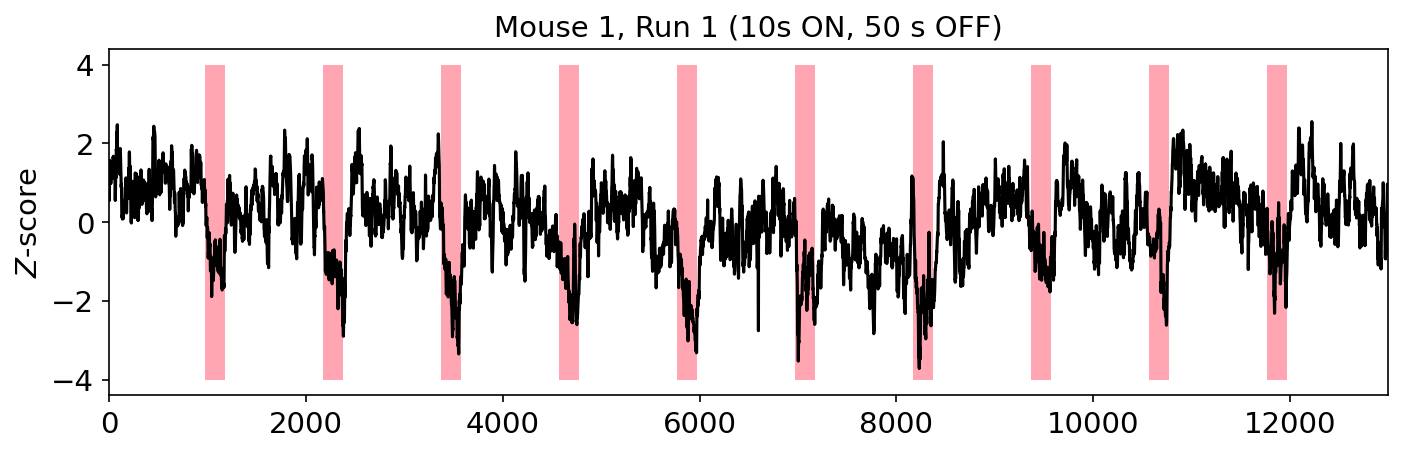

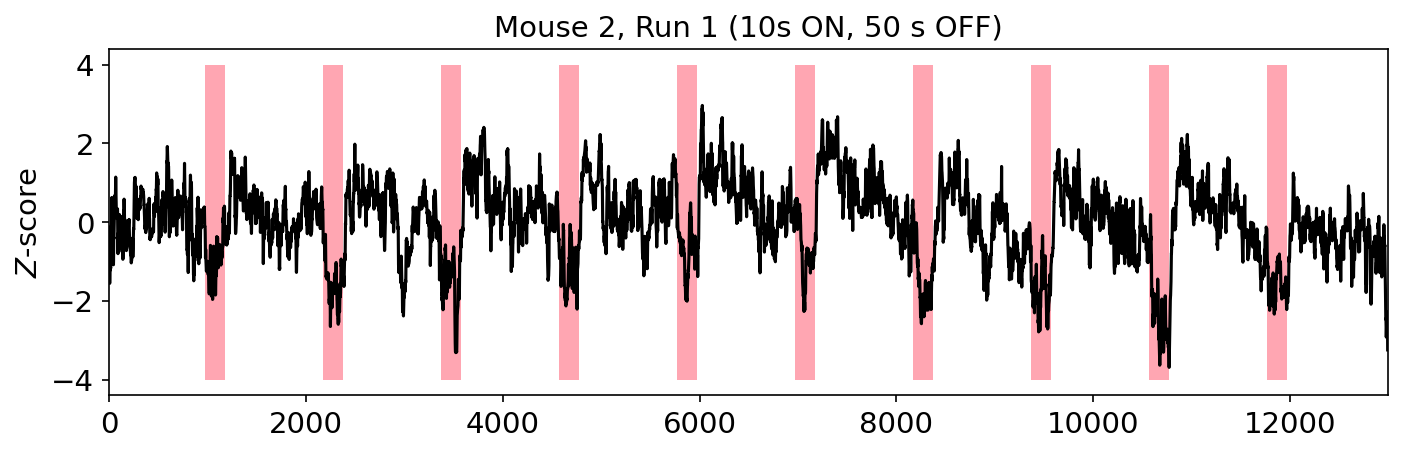

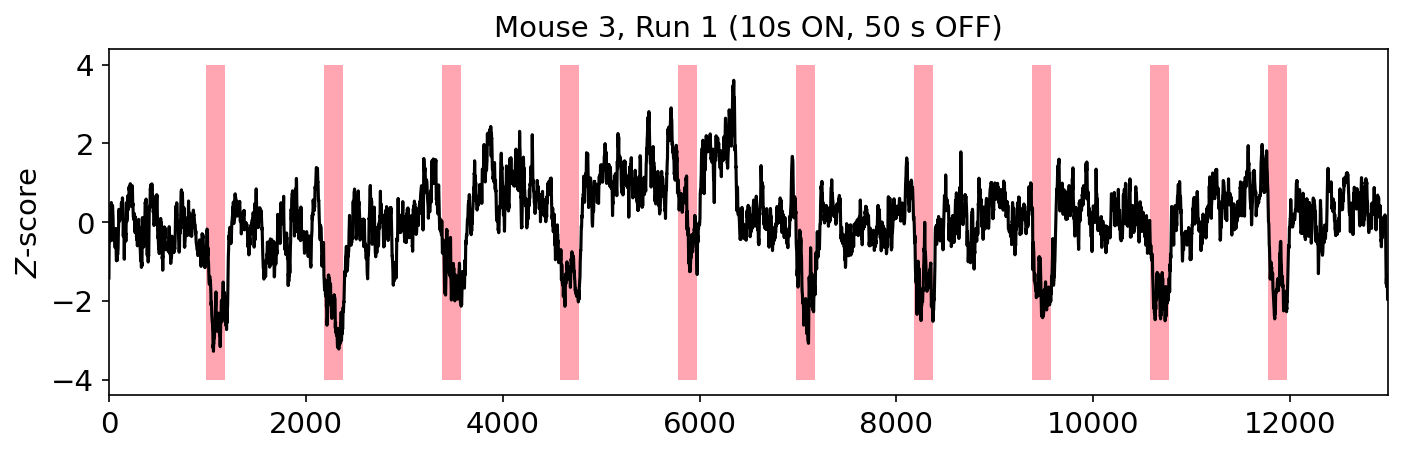

In [6]:
for (mouse, run, experiment), mouse_data in data_processed.groupby(['Mouse', 'Run', 'Experiment']):
    GCaMP_Z = mouse_data['GCaMP_Z'].to_numpy()
    Time = mouse_data['Time'].to_numpy()
    Onsets = indx_onsets.query("Mouse==@mouse & Run==@run")['Onsets'].to_numpy()
    
    fig = plt.figure(figsize=(11,3))
    plt.title(f'{mouse}, {run} ({experiment})')
    plt.ylabel('$Z$-score')

    plt.plot(GCaMP_Z, 'k', zorder=1)
    
    for ons in Onsets:
        plt.fill_between([ons,ons+10*sampling], -4, 4, color='#FF5E74', edgecolor=None, 
                         alpha=0.55, linestyle='--', zorder=-1)



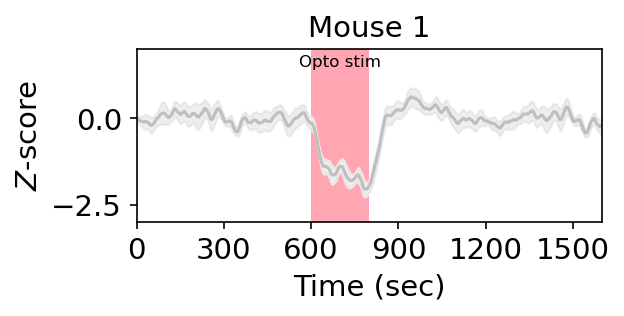

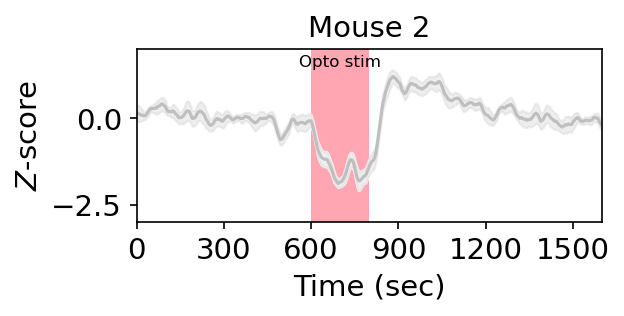

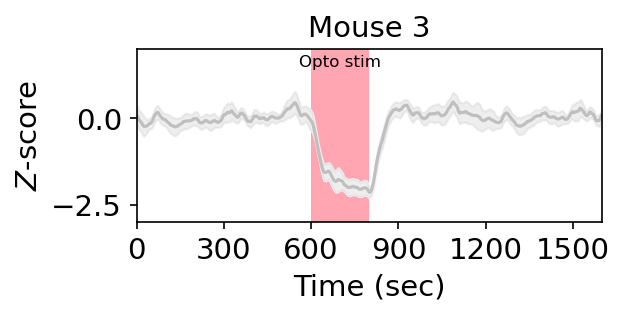

In [7]:
baseline = True

pre = 30*sampling
post = 50*sampling

for mouse, mouse_data in data_processed.groupby('Mouse'):
    trace = []
    for (run, experiment), run_data in mouse_data.groupby(['Run', 'Experiment']):
        GCaMP_Z = run_data['GCaMP_Z'].to_numpy()
        Time = run_data['Time'].to_numpy()
        Onsets = indx_onsets.query("Mouse==@mouse & Run==@run")['Onsets'].to_numpy()[:10]

        if baseline: offset = np.mean([GCaMP_Z[ons-pre:ons] for ons in Onsets])
        else: offset = 0
        [trace.append(GCaMP_Z[ons-pre:ons+post] - offset) for ons in Onsets]

    trace = np.stack(trace)
    trace = bn.move_mean(trace, window=20, min_count=1)
    time = np.arange(pre+post)

    mean = trace.mean(axis=0)
    sem = st.sem(trace, axis=0, nan_policy='omit')

    fig = plt.figure(figsize=(4,1.5))

    plt.fill_between([pre,pre+10*sampling], -4, 4, color='#FF5E74', edgecolor=None, 
                     alpha=0.55, linestyle='--')
    plt.text(s='Opto stim', x=pre+10*sampling*0.5, y=1.5, fontsize=8, ha='center')
    plt.fill_between(time, mean+sem, mean-sem, color='#FFFFFF')
    plt.fill_between(time, mean+sem, mean-sem, color='#BFBFBF', alpha=0.25)
    plt.plot(mean, color='#BFBFBF')


    plt.ylim([-3,2])

    plt.title(f'{mouse}')
    plt.ylabel('$Z$-score')
    plt.xlabel('Time (sec)')
    xticks = np.arange(0,pre+10*sampling+post,300)
    plt.xticks(xticks, xticks);

    

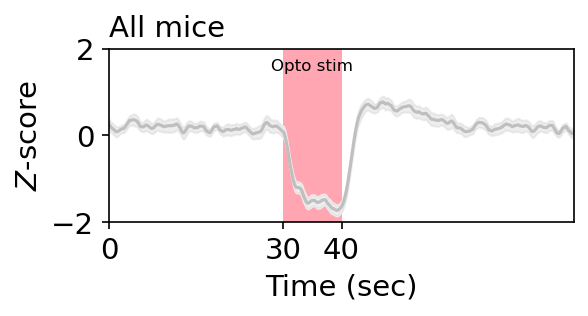

In [8]:
baseline = 0

pre = 30*sampling
post = 50*sampling

trace = []
for (mouse, run, experiment), mouse_data in data_processed.groupby(['Mouse', 'Run', 'Experiment']):
    GCaMP_Z = mouse_data['GCaMP_Z'].to_numpy()
    Time = mouse_data['Time'].to_numpy()
    Onsets = indx_onsets.query("Mouse==@mouse & Run==@run")['Onsets'].to_numpy()[:10]
    
    if baseline: offset = np.mean([GCaMP_Z[ons-pre:ons] for ons in Onsets])
    else: offset = 0
    [trace.append(GCaMP_Z[ons-pre:ons+post] - offset) for ons in Onsets]

trace = np.stack(trace)
trace = bn.move_mean(trace, window=20, min_count=1)
time = np.arange(pre+post)

mean = trace.mean(axis=0)
sem = st.sem(trace, axis=0, nan_policy='omit')
    
fig = plt.figure(figsize=(4,1.5))
    
plt.fill_between([pre,pre+10*sampling], -4, 4, color='#FF5E74', edgecolor=None, 
                 alpha=0.55, linestyle='--')
plt.text(s='Opto stim', x=pre+10*sampling*0.5, y=1.5, fontsize=8, ha='center')
plt.fill_between(time, mean+sem, mean-sem, color='#FFFFFF')
plt.fill_between(time, mean+sem, mean-sem, color='#BFBFBF', alpha=0.25)
plt.plot(mean, color='#BFBFBF')


plt.ylim([-2,2])

plt.title('All mice', x=0, ha='left')
plt.ylabel('$Z$-score')
plt.xlabel('Time (sec)')
xticks = np.array([0,pre,pre+10*sampling])
plt.xticks(xticks, xticks//sampling);

    

In [9]:
import matplotlib.patches as patches
import matplotlib.colors as colors

cmap = colors.LinearSegmentedColormap.from_list("", ["#0570b0", "white", '#e69f00'])


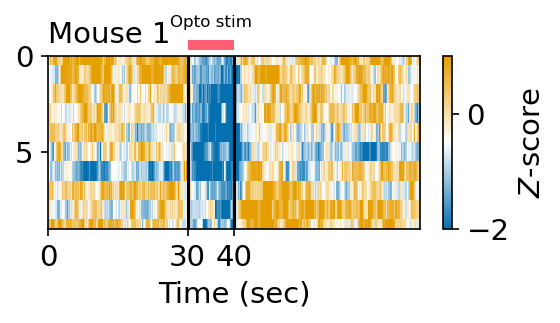

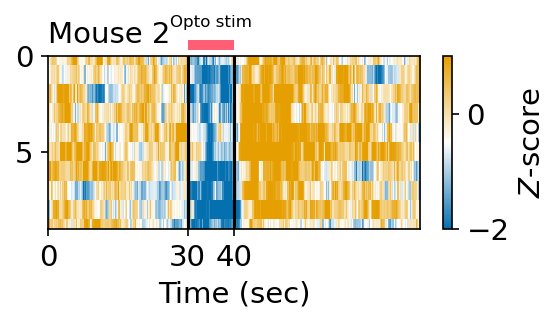

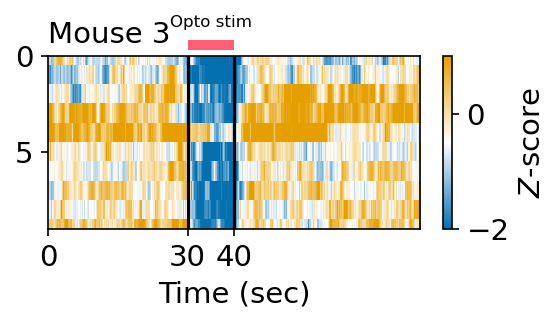

In [10]:
baseline = True

pre = 30*sampling
post = 50*sampling

for mouse, mouse_data in data_processed.groupby('Mouse'):
    trace = []
    for (run, experiment), run_data in mouse_data.groupby(['Run', 'Experiment']):
        GCaMP_Z = run_data['GCaMP_Z'].to_numpy()
        Time = run_data['Time'].to_numpy()
        Onsets = indx_onsets.query("Mouse==@mouse & Run==@run")['Onsets'].to_numpy()[:10]

        if baseline: offset = np.mean([GCaMP_Z[ons-pre:ons] for ons in Onsets])
        else: offset = 0
        [trace.append(GCaMP_Z[ons-pre:ons+post] - offset) for ons in Onsets]

    trace = np.stack(trace)
#     trace = bn.move_mean(trace, window=20*5, min_count=1)
    time = np.arange(pre+post)

    fig = plt.figure(figsize=(4,1.5))
    
    im = plt.imshow(trace, cmap=cmap, interpolation='nearest', aspect='auto', vmin=-2, vmax=1)
    plt.vlines([pre,pre+10*sampling], -0.5, Onsets.shape[0]-0.5, color='k')
    plt.gca().add_patch(patches.Rectangle((pre, -0.8), 10*sampling, 0.5, facecolor='#FF5E74', clip_on=False))
    plt.text(s='Opto stim', x=pre+10*sampling*0.5, y=-1.5, fontsize=8, ha='center')
    
    plt.colorbar(im, label='$Z$-score')

    plt.title(f'{mouse}', x=0, ha='left')
    plt.xlabel('Time (sec)')
    plt.ylim([9,0])
    xticks = np.array([0,pre,pre+10*sampling])
    plt.xticks(xticks, xticks//sampling);

    

## Figure 5n

#### Load data

In [11]:
data_path = Path(f'{base_dir}/Figure5n.csv')

data = pd.read_csv(data_path, header=[1,2,3,4], index_col=0).reset_index(drop=True)
data = data.melt(var_name=['Mouse','Run','Experiment','Channel'], value_name='Signal')
data = data.astype({'Signal':'float'})


/var/folders/ym/p44d7_tn1zjgj7254j6z1t9h0000gn/T/ipykernel_87854/2328948545.py:3: DtypeWarning: Columns (3,6,9,12,15,18,21) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(data_path, header=[1,2,3,4], index_col=0).reset_index(drop=True)


In [12]:
data_processed, indx_onsets = [], []
for (mouse, run, experiment), mouse_data in data.groupby(['Mouse', 'Run', 'Experiment']):
    GCaMP_raw = mouse_data.query("Channel=='465nm'").dropna()['Signal'].to_numpy()
    Isos_raw = mouse_data.query("Channel=='405nm'").dropna()['Signal'].to_numpy()
    Stim_raw = mouse_data.query("Channel=='Stim'").dropna()['Signal'].to_numpy()
    Time = np.array([x*np.round(1./sampling, 2) for x in range(len(GCaMP_raw))])


    # Donoise the signal.
    GCaMP_denoised = medfilt(GCaMP_raw, kernel_size=sampling+1)
    Isos_denoised = medfilt(Isos_raw, kernel_size=sampling+1)
    
    # Lowpass filtering. Use filtfilt() for zero phase filtering.
    b,a = butter(2, 5, btype='low', fs=sampling)
    GCaMP_denoised = filtfilt(b,a, GCaMP_denoised)
    Isos_denoised = filtfilt(b,a, Isos_denoised)

    # Motion correction.
    slope, intercept, r_value, p_value, std_err = linregress(x=Isos_denoised, y=GCaMP_denoised)
    GCaMP_est_motion = intercept + slope * Isos_denoised
    GCaMP_corrected = GCaMP_denoised - GCaMP_est_motion
    
    # dF/F
    b,a = butter(2, 0.001, btype='low', fs=sampling)
    baseline_fluorescence = filtfilt(b,a, GCaMP_denoised, padtype='even')
    GCaMP_dF_F = GCaMP_corrected / baseline_fluorescence
    
    # Z-score.
    GCaMP_Z = st.zscore(GCaMP_dF_F)
    
    temp = pd.DataFrame({'GCaMP_dF_F':GCaMP_dF_F, 'GCaMP_Z':GCaMP_Z, 'Time':Time})
    temp['Mouse'] = mouse
    temp['Run'] = run
    temp['Experiment'] = experiment
    data_processed.append(temp)
    
    # Extract the onsets of stimulation.
    onsets = np.argwhere(np.diff(Stim_raw, prepend=0)>0).flatten()
    offsets = np.argwhere(np.diff(Stim_raw, prepend=0)<0).flatten()
    onsets = onsets[0:1]
    offsets = offsets[0:1]
    
    temp = pd.DataFrame({'Onsets':onsets, 'Offsets':offsets})
    temp['Mouse'] = mouse
    temp['Run'] = run
    temp['Experiment'] = experiment
    indx_onsets.append(temp)
    
data_processed = pd.concat(data_processed, ignore_index=True)
indx_onsets = pd.concat(indx_onsets, ignore_index=True)


/var/folders/ym/p44d7_tn1zjgj7254j6z1t9h0000gn/T/ipykernel_87854/3025454283.py:6: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for mouse, mouse_data in data_processed.groupby(['Mouse']):


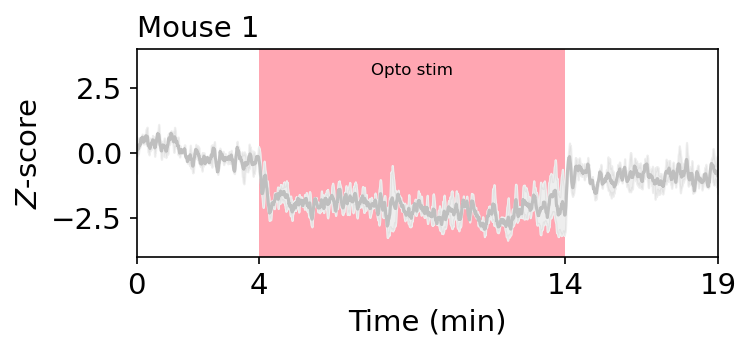

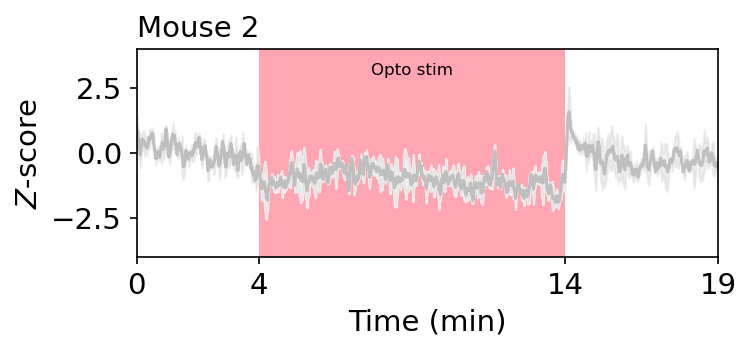

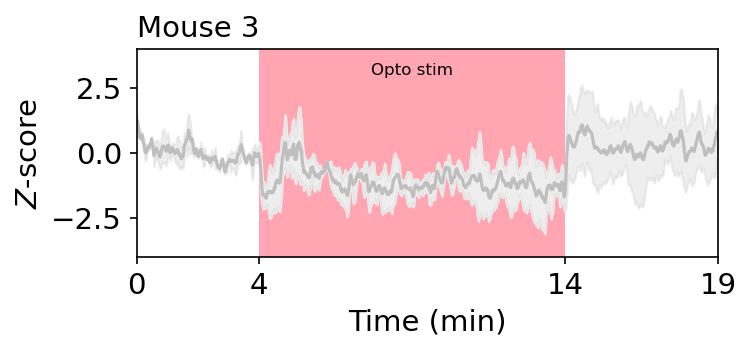

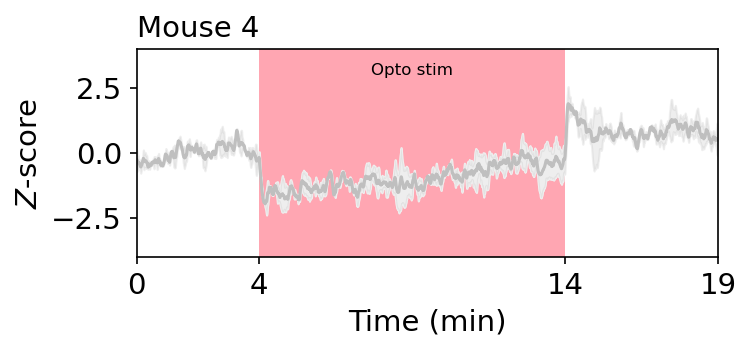

In [13]:
baseline = True

pre = int(4*sampling*60)
post = int(15*sampling*60)

for mouse, mouse_data in data_processed.groupby(['Mouse']):
    trace = []
    for (run, experiment), run_data in mouse_data.groupby(['Run', 'Experiment']):
        GCaMP_Z = run_data['GCaMP_Z'].to_numpy()
        Time = run_data['Time'].to_numpy()
        Onsets = indx_onsets.query("Mouse==@mouse & Run==@run")['Onsets'].to_numpy()
        
        if baseline: offset = np.mean(GCaMP_Z[Onsets[0]-pre:Onsets[0]])
        else: offset = 0
        trace.append(GCaMP_Z[Onsets[0]-pre:Onsets[0]+post] - offset)

    trace = np.stack(trace)
    trace = bn.move_mean(trace, window=20*5, min_count=1)
    time = np.arange(pre+post)

    mean = trace.mean(axis=0)
    sem = st.sem(trace, axis=0, nan_policy='omit')

    fig = plt.figure(figsize=(5,1.8))
    
    plt.fill_between([pre,pre+10*sampling*60], -4, 4, color='#FF5E74', edgecolor=None, 
                     alpha=0.55, linewidth=0)
    plt.text(s='Opto stim', x=pre+10*sampling*60*0.5, y=3, fontsize=8, ha='center')
    plt.fill_between(time, mean+sem, mean-sem, color='#FFFFFF')
    plt.fill_between(time, mean+sem, mean-sem, color='#BFBFBF', alpha=0.25)
    plt.plot(mean, color='#BFBFBF')
    

    plt.ylim([-4,4])

    plt.title(f'{mouse}', x=0, ha='left')
    plt.ylabel('$Z$-score')
    plt.xlabel('Time (min)')
    xticks = np.array([0,pre,pre+10*sampling*60,pre+post])
    plt.xticks(xticks, xticks//(sampling*60));
    
    

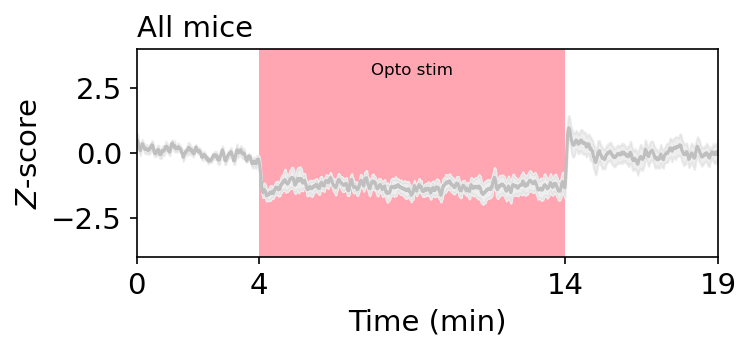

In [14]:
pre = int(4*sampling*60)
post = int(15*sampling*60)

trace = []
for (mouse, run, experiment), mouse_data in data_processed.groupby(['Mouse','Run','Experiment']):
    GCaMP_Z = mouse_data['GCaMP_Z'].to_numpy()
    Time = mouse_data['Time'].to_numpy()
    Onsets = indx_onsets.query("Mouse==@mouse & Run==@run")['Onsets'].to_numpy()

    if baseline: offset = np.mean(GCaMP_Z[Onsets[0]-pre:Onsets[0]])
    else: offset = 0
    trace.append(GCaMP_Z[Onsets[0]-pre:Onsets[0]+post] - offset)
    

trace = np.stack(trace)
trace = bn.move_mean(trace, window=20*5, min_count=1)
time = np.arange(pre+post)

mean = trace.mean(axis=0)
sem = st.sem(trace, axis=0, nan_policy='omit')

fig = plt.figure(figsize=(5,1.8))

plt.fill_between([pre,pre+10*sampling*60], -4, 4, color='#FF5E74', edgecolor=None, 
                 alpha=0.55, linewidth=0)
plt.text(s='Opto stim', x=pre+10*sampling*60*0.5, y=3, fontsize=8, ha='center')
plt.fill_between(time, mean+sem, mean-sem, color='#FFFFFF')
plt.fill_between(time, mean+sem, mean-sem, color='#BFBFBF', alpha=0.25)
plt.plot(mean, color='#BFBFBF')


plt.ylim([-4,4])

plt.title('All mice', x=0, ha='left')
plt.ylabel('$Z$-score')
plt.xlabel('Time (min)')
xticks = np.array([0,pre,pre+10*sampling*60,pre+post])
plt.xticks(xticks, xticks//(sampling*60));
